This file will (hopefully) show how our spectra data is structured and how to use them to create colors for Pham & Kaltenegger (2022).

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load all possible combinations

Note: we are creating (loading) a grid with resolution of 0.05, subjecting to the condition:

$$ \sum_{i=1}^{6} \theta_i = 1; 0 \leq \theta_i \leq 1 $$

where $\theta_i$ is each component's value (ranging between $[0,1]$) and there are $6$ components (6 representative components of modern Earth: cloud, snow, sand, sandwater, basalt, vegetation).

In [4]:
# load all component combinations that sum to unity
component_names, unity_surface_combinations = pickle.load(open("surface_combinations.pkl", "rb"))

In [5]:
unity_surface_combinations_df = pd.DataFrame(unity_surface_combinations, 
                                             columns=component_names)

In [6]:
unity_surface_combinations_df

,cloud,snow,sand,seawater,basalt,veg
0,0.00,0.00,0.00,0.00,0.00,1.00
1,0.00,0.00,0.00,0.00,0.05,0.95
2,0.00,0.00,0.00,0.00,0.10,0.90
3,0.00,0.00,0.00,0.00,0.15,0.85
4,0.00,0.00,0.00,0.00,0.20,0.80
...,...,...,...,...,...,...
53125,0.95,0.00,0.00,0.00,0.05,0.00
53126,0.95,0.00,0.00,0.05,0.00,0.00
53127,0.95,0.00,0.05,0.00,0.00,0.00
53128,0.95,0.05,0.00,0.00,0.00,0.00


## Load spectra

In [7]:
# unit is W/m^2/micron
all_spectra = pickle.load(open("all_spectra.pkl", "rb"))

In [8]:
all_spectra.shape

(53130, 10000)

In [9]:
# unit is micron
wavelength = pickle.load(open("wavelength.pkl", "rb"))
wavelength.shape

(10000,)

Here, we can see that all_spectra has the shape of (combination, wavelength). Working with unity_surface_combinations_df, we can match the spectra and the surface combination. For example, let's get the spectra of an a surface with 25% cloud and 75% snow:

In [10]:
combination_idx = unity_surface_combinations_df.loc[(unity_surface_combinations_df["cloud"] == 0.25) &
                                                    (unity_surface_combinations_df["snow"] == 0.75)].index[0]

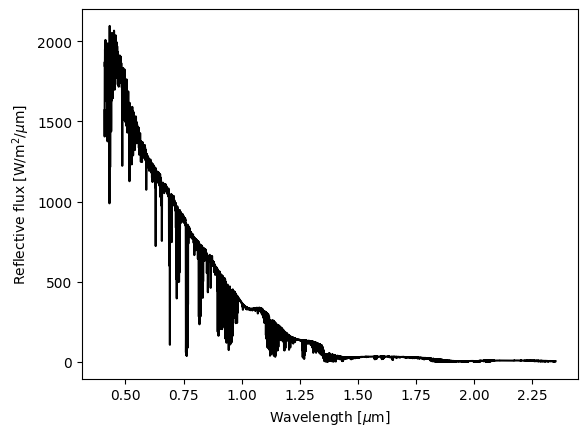

In [11]:
plt.plot(wavelength, all_spectra[combination_idx], 'k-')
plt.xlabel(r"Wavelength [$\mu$m]");
plt.ylabel(r"Reflective flux [W/m$^2$/$\mu$m]");

## Make idealized filters

In [36]:
FILTER_SIZE = 0.08 # in micron
FILTER_MIN  = 0.45 # starting wavelength
FILTER_MAX  = 2.35 # final wavelength

In [37]:
# number of filters we can fit with this set up
N_FILTERS = int(np.floor((FILTER_MAX - FILTER_MIN)/FILTER_SIZE))
# some generic filter names (for plotting)
filter_names = [f"f{i}" for i in range(N_FILTERS)]
nice_filter_names = []
for i, _ in enumerate(filter_names):
    nice_filter_names.append(r"$f_" + str(i+1) + "$")

In [38]:
def filter_func(initial, x, step=FILTER_SIZE):
    """ An idealized filter, starting at some
        initial wavelength, ending at initial + step,
        for some step size.
        
        Parameters:
            initial (float): the initial wavelength
                where the filter starts.
            x (array): all the wavelengths (just
                pass the wavelength array here).
            step (float, optional): the step size.
        
        Returns:
            (array): filter response, same length as x.
    """
    # create output array
    output = np.zeros(len(x))
    
    # find where the filter is peaking
    inrange = (x >= initial) & (x < initial + step)
    
    # set peak to 1, 0 elsewhere
    output[inrange] = 1
    output[~inrange] = 0
    
    return output

TypeError: annotate() missing 1 required positional argument: 'text'

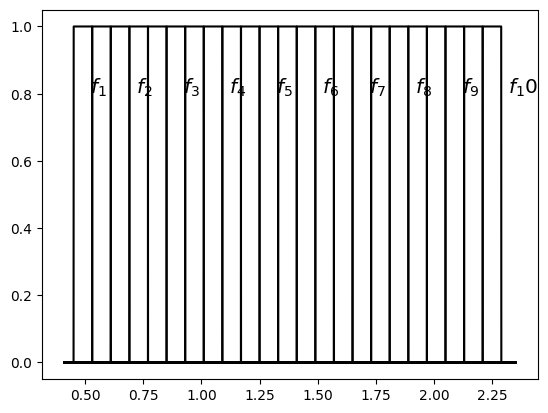

In [39]:
# plot the filters
for i in range(N_FILTERS):
    filter_pos = FILTER_MIN + FILTER_SIZE*i
    filter_response = filter_func(filter_pos, wavelength, step=FILTER_SIZE)
    plt.plot(wavelength, filter_response, c='k',)
# annotate plot
for i, filter_name in enumerate(nice_filter_names):
    plt.annotate(text=filter_name, xy=(0.52 + 0.2*i, 0.8), fontsize='x-large')

plt.annotate(s='', xy=(0.45 + 0.2*4, 0.6), xytext=(0.45 + 0.2*5,0.6), arrowprops=dict(arrowstyle='<->'))
plt.annotate('0.2 \n $\mu$m',xy=(1.3, 0.45))
plt.ylim([0,1.05])
plt.xlim([0.4, 2.35])
plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel(r'Filter response');

## Make colors from filters + spectra

In [33]:
colors = np.zeros((N_FILTERS, len(all_spectra)))

for i in range(N_FILTERS):
    filter_pos = FILTER_MIN + FILTER_SIZE*i
    filter_response = filter_func(filter_pos, wavelength, step=FILTER_SIZE) * all_spectra
    # can also np.quad to integrate, but trapz is plenty precise here (and faster!)
    colors[i] = np.trapz(filter_response, x=wavelength, axis=1)

In [34]:
colors = colors.transpose()

In [35]:
colors.shape

(53130, 19)

In [28]:
with open("colors.pkl", "wb") as f:
    pickle.dump(colors, f)

In [ ]:
wavelength.shape

(10000,)

Here, colors is in the dimension of (combination, filters). We can match the color with combination from unity_surface_combinations_df, similar to how we did it before with spectra. We can also save this colors array to use as the dataset for machine learning.